<a href="https://colab.research.google.com/github/Sauravskv07/NNFL_Project/blob/master/DDQN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import keras
import cv2
from skimage.color import rgb2gray
from collections import deque
from PIL import Image, ImageDraw
from skimage.transform import resize

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, Flatten, MaxPooling2D, ZeroPadding2D, AveragePooling2D, TimeDistributed
from keras.layers import Convolution2D as Conv2D
from keras.optimizers import Adam, RMSprop, SGD 
import imageio
from keras.models import load_model, save_model 
from skimage import img_as_ubyte
import tensorflow as tf

In [0]:
#PARAMETERS
ENV_NAME = 'BreakoutDeterministic-v4'
#ENV_NAME = 'Pong-v0'
MEM_SIZE = 200000 # add one 0
GAMMA = 0.99
EPSILON = 1
EPSILON_MIN = 0.001
LEARNING_RATE = 0.00020
MOMENTUM = 0.001 
NUM_EPISODES = 10000
MINIBATCH_SIZE = 32
TGT_UPDATE_FREQ = 30
VIS_DIR = "k7"
MODEL_NAME = "m4.h5"
NUM_EXPLORE = 500
EPSILON_MAX = 1
TOTAL_FRAMES = 1500000

In [0]:
LOSS_HISTORY = []
REWARD_HISTORY = []
filepath= 1
FCNT = 0
if not os.path.exists("models"): 
    os.mkdir("models")

In [0]:
class Replay_Memory: 
    def __init__(self, MEM_SIZE = 2000): 
        self.memory = deque(maxlen = MEM_SIZE)
        self.max_size = MEM_SIZE
    def add(self,  state, action, reward, next_state, done): 
        #if(len(self.memory) == self.max_size):
        #    self.memory.popleft()
        self.memory.append(( state, action, reward, next_state, done)); 

In [0]:
class Agent:
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.memory = Replay_Memory(MEM_SIZE)
        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_max = EPSILON_MAX
        self.epsilon_min = EPSILON_MIN
        self.total_frame = TOTAL_FRAMES
        self.slope = (self.epsilon_max - self.epsilon_min)/self.total_frame
        self.epsilon_decay = EPSILON_DECAY
        self.lr = LEARNING_RATE
        self.momentum = MOMENTUM
        self.model = self.build_model()
        self.target_model = self.get_tgt_model()
        #print(type(self.target_model))

    

    def build_model(self):
        model = Sequential()
        input_dim = [84,84,4]
        #Removing this layer as of now
        #model.add(keras.layers.Lambda(lambda x: x/255.0, input_shape = input_dim)) 
        model.add(Conv2D(filters= 32, kernel_size = [8,8], strides =4, kernel_initializer='normal', input_shape = input_dim, padding='valid', activation= 'relu',use_bias=False, name = 'Conv1'))
        model.add(Conv2D(filters= 64, kernel_size = [4,4], strides =2, padding='valid', kernel_initializer= 'normal', activation= 'relu',use_bias=False, name = 'Conv2'))
        model.add(Conv2D(filters= 64, kernel_size = [3,3], strides =1, padding='valid', kernel_initializer= 'normal', activation= 'relu',use_bias=False, name = 'Conv3'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        model.summary()
        model.compile(loss = tf.keras.losses.Huber() , optimizer = Adam(self.lr))
        return model

    def get_tgt_model(self):
        self.target_model = keras.models.clone_model(self.model)
        return self.target_model
        
    def update_target_model(self): 
        self.target_model.set_weights(self.model.get_weights()) 
        return

    def next_action(self, state):
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_max - self.slope*(FCNT)
        if (np.random.rand() <= self.epsilon):
            return env.action_space.sample()
        
        q_values = self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
            self.memory.add(state, action, reward, next_state, done)

    def replay(self, batch_size, filepath):

        minibatch = random.sample(self.memory.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
      
            q_tgt = self.target_model.predict(np.expand_dims(next_state, axis = 0))[0]
            q_base = self.model.predict(np.expand_dims(next_state, axis = 0))[0]
            main_action = np.argmax(q_base)
            dbl_target = q_tgt[main_action]
            target = reward
        
            if not done:
                target = reward + (self.gamma * dbl_target)
            target_f = self.model.predict(np.expand_dims(state, axis = 0))
            target_f[0][action] = target

            filename = "models/" + str(filepath) + ".hdf5"

            history = self.model.fit(np.expand_dims(state, axis = 0), target_f, epochs=1, verbose=0)#, callbacks = [Callbacks])
 
            LOSS_HISTORY.append(history.history['loss'])
        if(filepath % TGT_UPDATE_FREQ == 0):
            self.update_target_model()
            print("Target model updated Successfully!")

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [0]:
def generate_gif(frame_number, frames_for_gif, reward, path, e):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """

    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"episode_{0}_frame_{1}_reward_{2}.gif".format(e, frame_number, reward)}', 
                    frames_for_gif, duration=1/100)

In [0]:
def preprocess(frame):
    
    resized = cv2.resize(frame, (84, 84), interpolation = cv2.INTER_AREA)

    #print(resized)
    #plt.imshow(resized)
    #plt.show()
    #RGB to Gray
    #frame = (0.21 * frame[:,:,:1]) + (0.72 * frame[:,:,1:2]) + (0.07 * frame[:,:,-1:])
    frame_gray = rgb2gray(resized)
    #plt.imshow(frame_gray , cmap='gray')
    #plt.show()
    return frame_gray
    

In [0]:
env = gym.make(ENV_NAME)
agent = Agent(env)

#INITIAL EXPLORATION: 
for e in range(NUM_EXPLORE):
    state = env.reset()
    for i in range(0,random.randint(1,10)):
      state, _, _, _ = env.step(1)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    #rgb_frames.append(state)
    for i in range(4): 
        frames.append(processed_frame)
        
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        agent.epsilon = 1
        action = env.action_space.sample()

        #execute action
        next_state, reward, done, info = env.step(action)
        
        if(itr%25==0):
          rgb_frames.append(next_state)
        ### CRITICAL

        
        #REWARD CLIPPING IS DONE HERE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        

        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)

        next_state = np.stack(frames[-4:], axis = 2)
        if(len(frames) != 4):
            print("issue!!")

        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if done: 
            if(e % 100 == 0):
                print("Finished exploring for {} episodes".format(e))
            break
print("EXPLORATION STEP COMPLETED")





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 20, 20, 32)        8192      
_________________________________________________________________
Conv2 (Conv2D)               (None, 9, 9, 64)          32768     
_________________________________________________________________
Conv3 (Conv2D)               (None, 7, 7, 64)          36864     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 1,686,020
Trainable params: 1,686,020
Non-trainable params: 0
________________________________________

In [0]:
#######
#TRAIN# 
#######
rew_list = []
for e in range(1, NUM_EPISODES+1):
    state = env.reset()
    for i in range(0,random.randint(1,10)):
      state, _, _, _ = env.step(1)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)
    for i in range(4):
        frames.append(processed_frame)
    
    
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        #select an action
        action = agent.next_action(state)
        FCNT = FCNT + 1
        #execute action
        next_state, reward, done, info = env.step(action)

        
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        
        total_reward = total_reward + reward

        processed_frame = preprocess(next_state)

        processed_frame = processed_frame.astype(np.uint8)
        
        frames = frames[-3:]
        
        frames.append(processed_frame)
        
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if(FCNT % 50000 == 0):
          fname = "models/tmp_model" + str(FCNT) + ".h5"
          save_model(agent.model, fname)

        

        if done:

            agent.replay(MINIBATCH_SIZE, filepath)
            filepath = filepath + 1 

            if(filepath%50==0):
              generate_gif(itr, rgb_frames, 1, "gif/")

            REWARD_HISTORY.append(total_reward)
            
            print("Total Reward = ",total_reward,"Num Frames = ",FCNT," EPISODE NUMBER = ",e, "Epsilon = ",agent.epsilon)

            break

    
    #print(rew_list)

    

agent.save("models/" + MODEL_NAME)
print("Model Saved Successfully!! , Partyyyy")







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Total Reward =  0.0 Num Frames =  152  EPISODE NUMBER =  1 Epsilon =  0.999849151
Total Reward =  0.0 Num Frames =  290  EPISODE NUMBER =  2 Epsilon =  0.999711289
Total Reward =  5.0 Num Frames =  629  EPISODE NUMBER =  3 Epsilon =  0.999372628
Total Reward =  2.0 Num Frames =  836  EPISODE NUMBER =  4 Epsilon =  0.999165835
Total Reward =  0.0 Num Frames =  973  EPISODE NUMBER =  5 Epsilon =  0.999028972
Total Reward =  1.0 Num Frames =  1139  EPISODE NUMBER =  6 Epsilon =  0.998863138
Total Reward =  2.0 Num Frames =  1364  EPISODE NUMBER =  7 Epsilon =  0.998638363
Total Reward =  1.0 Num Frames =  1546  EPISODE NUMBER =  8 Epsilon =  0.998456545
Total Reward =  1.0 Num Frames =  1703  EPISODE NUMBER =  9 Epsilon =  0.998299702
Total Reward =  4.0 Num Frames =  2000  EPISODE NUMBER =  10 Epsilon =  0.998002999
Total Reward =  0.0 Num Frames =  2156  EPISODE NUMBER =  11 Epsilon =  

KeyboardInterrupt: ignored

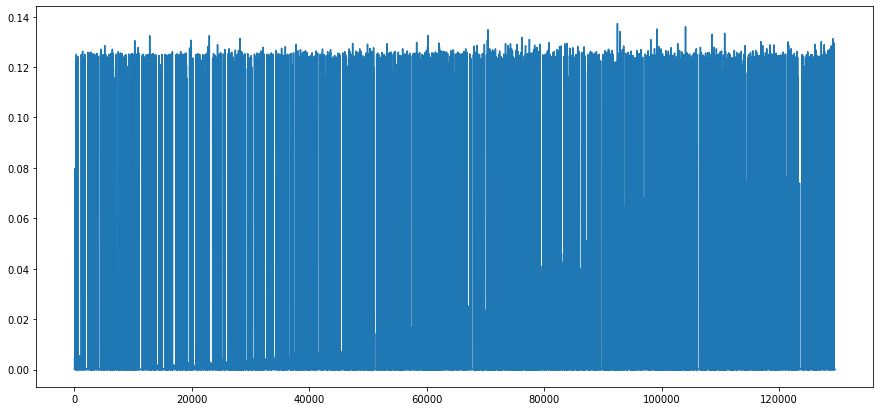

In [0]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15, 7))
plt.plot(LOSS_HISTORY)
plt.show()

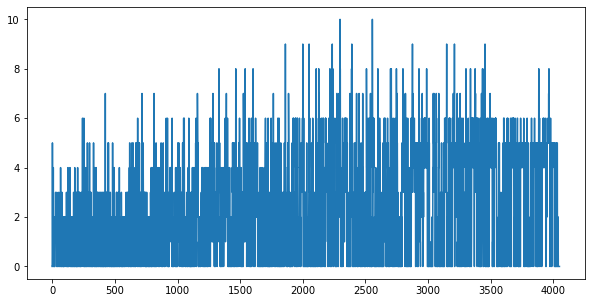

In [0]:
plt.figure(figsize = (10, 5))
plt.plot(REWARD_HISTORY)
plt.show()

In [0]:
rew_list = []
for e in range(10):
    state = env.reset()
    state, _, _, _ = env.step(1)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)
    for i in range(4):
        frames.append(processed_frame)
   
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        #select an action
        action = np.argmax(agent.model.predict(np.expand_dims(state, axis=0))[0])
        FCNT = FCNT + 1
        #execute action
        next_state, reward, done, info = env.step(action)

        rgb_frames.append(next_state)
       
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
       
        if(FCNT%100==0):
          print(FCNT, action, total_reward, info['ale.lives'])
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        #agent.store_experience(state, action, reward, next_state, done)
        state = next_state
       
        if done:
            rew_list.append(total_reward)
            #REWARD_HISTORY.append(total_reward)
            #rew_list.append(total_reward)
           
            #if(e % 25 == 0):
            print("Finished episode ", e , "/", NUM_EPISODES, " Total reward = ", sum(rew_list)/len(rew_list))
            if not os.path.exists("test"):
                os.mkdir("test")
            generate_gif(len(rgb_frames), rgb_frames, sum(rew_list)/(len(rew_list)), "test/", e)
           
            #rew_list = []
            break

   


#agent.save("models/" + MODEL_NAME)
print("Testing Complete")

1139600 2 0.0 4
1139700 2 0.0 4
1139800 2 0.0 4
1139900 2 0.0 4
1140000 2 0.0 4
1140100 2 0.0 4
1140200 2 0.0 4
1140300 2 0.0 4
1140400 2 0.0 4
1140500 2 0.0 4
1140600 2 0.0 4
1140700 2 0.0 4
1140800 2 0.0 4
1140900 2 0.0 4
1141000 2 0.0 4
1141100 2 0.0 4
1141200 2 0.0 4
1141300 2 0.0 4
1141400 2 0.0 4
1141500 2 0.0 4
1141600 2 0.0 4
1141700 2 0.0 4
1141800 2 0.0 4
1141900 2 0.0 4
1142000 2 0.0 4
1142100 2 0.0 4
1142200 2 0.0 4
1142300 2 0.0 4
1142400 2 0.0 4
1142500 2 0.0 4
1142600 2 0.0 4
1142700 2 0.0 4
1142800 2 0.0 4
1142900 2 0.0 4
1143000 2 0.0 4
1143100 2 0.0 4
1143200 2 0.0 4
1143300 2 0.0 4
1143400 2 0.0 4
1143500 2 0.0 4
1143600 2 0.0 4
1143700 2 0.0 4
1143800 2 0.0 4
1143900 2 0.0 4
1144000 2 0.0 4
1144100 2 0.0 4
1144200 2 0.0 4
1144300 2 0.0 4
1144400 2 0.0 4
1144500 2 0.0 4
1144600 2 0.0 4
1144700 2 0.0 4
1144800 2 0.0 4
1144900 2 0.0 4
1145000 2 0.0 4
1145100 2 0.0 4
1145200 2 0.0 4
1145300 2 0.0 4
1145400 2 0.0 4
1145500 2 0.0 4
1145600 2 0.0 4
1145700 2 0.0 4
1145800 

KeyboardInterrupt: ignored

In [0]:
 generate_gif(len(rgb_frames), rgb_frames[:1000], sum(rew_list), "test/", e)


In [0]:
print(len(rgb_frames))

15513
